# Principal Components Echo State Networks

## Import

In [2]:
from numpy import *
from matplotlib import pyplot as plt
from scipy.sparse import rand as sprand
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs as speigs

## Helper functions

In [3]:
def normalize_input(inputSequence):
    iMu = mean(inputSequence, axis=0)
    iMax = amax(abs(inputSequence), axis=0)
    normInputSequence = (inputSequence-iMu)/iMax
    return normInputSequence

## PC-ESN Class

In [4]:
class PCESN():
    def __init__(self,nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius,sigma2, phi2,eta):
        print('Creating PC-ESN...')
        # Structure
        self.nInputUnits = nInputUnits
        self.nReservoirUnits = nReservoirUnits
        self.nOutputUnits = nOutputUnits
        
        # Parameters
        self.spectralRadius = spectralRadius # 0<sR<1 to ensure ESP! default 0.4???
        self.sigma2 = sigma2 # default 0.1???
        self.phi2 = phi2 # default 1???
        self.eta = eta # learning rate, default???
        
        # Initalize input sum and mean variables
        self.inputMean = 0 
        self.inputAbs = 1e-8 # small enough???
        self.i = 0

        ## Initialize weights
        # H.Jaeger (Sparse reservoir weights)
        success = 0                                             
        while success == 0: # following block might fail
            try:
                self.Wres = sprand(nReservoirUnits, nReservoirUnits, density=10/nReservoirUnits)
                self.Wres = self.Wres.toarray()
                self.Wres[self.Wres!=0] -= 0.5 # modify only nonzero elements
                self.Wres = csr_matrix(self.Wres) # back to sparse
                maxVal = max(abs(speigs(A=self.Wres, k=1, which='LM')[0]))
                self.Wres /= maxVal
                success = 1
            except:
                success = 0   
        self.Wres *= self.spectralRadius
        
        self.Win = eye(nInputUnits)
        self.Wself = (2.0*random.rand(nReservoirUnits, nInputUnits)-1.0) # init not mentioned???
        self.Wfb = (2.0 * random.rand(nReservoirUnits, nOutputUnits)- 1.0)
        self.Wout = (2.0 * random.rand(nOutputUnits,nReservoirUnits)- 1.0) # init not mentioned???
        self.Wdir = (2.0 * random.rand(nOutputUnits,nInputUnits)- 1.0)
        #self.Wtrain = zeros((nOutputUnits, nInputUnits + nReservoirUnits)) - just a combination of [Wout Wdir]
        self.r = zeros((nReservoirUnits,1))
        self.o = zeros((nOutputUnits,1))

        # Initialize covariance matrix
        self.V = self.sigma2 * eye(nInputUnits + nReservoirUnits)
        
        print('Successful!')
        
    def train(self, inputSample,targetSample):
        inputSample = inputSample[:,newaxis]
        targetSample = targetSample[:,newaxis]
        
        # Normalize and center input
        self.inputMean = self.inputMean + (inputSample-self.inputMean)/(self.i+1)
        inputSample -= self.inputMean
        self.inputAbs = maximum(self.inputAbs, absolute(inputSample))
        inputSample /= self.inputAbs
        self.i += 1 # update index

        self.s = tanh(self.Win @ inputSample) # update self-organized layer
        #self.s = self.s[:,newaxis]
        self.r = tanh(self.Wres @ self.r + self.Wself @ self.s + self.Wfb @ self.o)
        self.c = vstack((self.r, self.s))

        self.Wtrain = hstack((self.Wout,self.Wdir)) 
        self.o = self.Wtrain @ self.c

        Vprev = self.V
        self.V = linalg.inv(linalg.inv(Vprev) + (1/self.sigma2) * self.c @ self.c.T)

        a = self.V @ linalg.inv(Vprev) @ self.Wtrain.T
        b = 1/self.sigma2 * (self.V @ self.c) @ targetSample.T

        self.Wtrain = sum([a.T, b.T], axis=0)

        # Calculate GHL update 
        triang = tril(self.s @ self.s.T)
        dWin = self.eta*(self.s@inputSample.T - triang @ self.Win)

        self.Win += dWin # update Win matrix

## Process data

In [5]:
nInputs = 21
nOutputs = 7
split = 0.5

data = genfromtxt('Sarcos.csv', delimiter=',')
ind = round(split*data.shape[0])

uTrain = data[0:ind,0:nInputs]
yTrain = data[0:ind,nInputs:]
uTest = data[ind:,0:nInputs]
yTest = data[ind:,nInputs:]

# Normalize input
uTrain = normalize_input(uTrain)
uTest = normalize_input(uTest)

## Demo

In [29]:
nInputUnits = 21
nReservoirUnits = 500
nOutputUnits = 7
spectralRadius = 0.4
sigma2 = 0.1
phi2 = 1
eta = 0.1

pcesn = PCESN(nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius,sigma2,phi2,eta)

data_len = uTrain.shape[0]
output = zeros((7,data_len,1))

for iInput in range(1000):
    pcesn.train(uTrain[iInput,:],yTrain[iInput,:])
    output[:,iInput] = pcesn.o
    

Creating PC-ESN...
Successful!


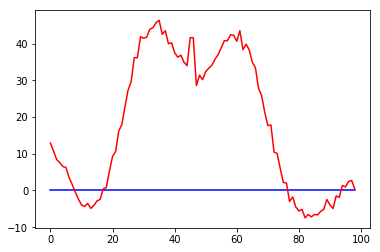

In [31]:
plt.plot(output[0,-100:-1],'b')
plt.plot(yTrain[-100:-1,0],'r')

## Useless(?) stuff

In [120]:
# Init
self.noiseLevel = 0.0
self.leakingRate = 1
self.forgetPoints = 100
self.reg = 1e-5 # If ridge regression!!! (something else than 1)

self.RLS_lambda = 0.9999995
self.RLS_delta = 0.000001

self.trained = 0
self.pseudo = True

# init default
self.inputScaling = ones((nInputUnits, 1)) # MAKE SURE INPUT IS NORMALIZED!!!
self.inputShift = zeros((nInputUnits, 1))
self.teacherScaling = ones((nOutputUnits, 1)) # DOES TEACHER SCALING MAKE ANY DIFFERENCE???
self.teacherShift = zeros((nOutputUnits, 1))
self.teacherForcing = True # Desired output y_teacher instead of predicted y -> Ridge regression!!!  
self.feedbackScaling = zeros((nOutputUnits, 1))

NameError: name 'self' is not defined